In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm.notebook import tqdm, trange

In [2]:
import torch
print(torch.version.cuda)

11.8


In [3]:
torch.set_float32_matmul_precision("high")

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            self.conv_block(3, 64),     # B x 64 x 64 x 64
            self.conv_block(64, 128),   # B x 128 x 32 x 32
            self.conv_block(128, 128),  # B x 128 x 16 x 16
            self.conv_block(128, 128),  # B x 128 x 8 x 8
            self.conv_block(128, 128),  # B x 128 x 4 x 4
            self.conv_block(128, 128),  # B x 128 x 2 x 2
        )
        self.flatten = nn.Flatten()
        self.z_mu = nn.Linear(128 * 2 * 2, 200)
        self.z_logvar = nn.Linear(128 * 2 * 2, 200)

    @staticmethod
    def conv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(1e-2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        return self.z_mu(x), self.z_logvar(x)

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(200, 128 * 2 * 2) # match the input
        self.deconv_layers = nn.Sequential(
            self.deconv_block(128, 128),    # B x 128 x 2 x 2
            self.deconv_block(128, 128),    # B x 128 x 4 x 4
            self.deconv_block(128, 128),    # B x 128 x 8 x 8
            self.deconv_block(128, 128),    # B x 128 x 16 x 16
            self.deconv_block(128, 64),     # B x 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1), # B x 3 x 64 x 64
            nn.Sigmoid()
        )

    @staticmethod
    def deconv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(1e-2)
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 128, 2, 2)
        return self.deconv_layers(x)

In [6]:
class Sampling(nn.Module):
    def forward(self, z_mean, z_logvar):
        epsilon = torch.randn_like(z_mean)
        return z_mean + torch.exp(0.5 * z_logvar) * epsilon

In [7]:
def KL_Divergence_Loss(z_mean,z_logvar):
    loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    loss = loss.mean()
    return loss

criterion = nn.MSELoss(reduction='mean')

In [8]:
device = (
    torch.device("mps") if torch.backends.mps.is_available() else
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("cpu")
)
print(f"Using device: {device}")

Using device: cuda


In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.sampling_layer = Sampling()

    def forward(self, x):
        z_mean, z_logvar = self.encoder(x)
        kl_loss = KL_Divergence_Loss(z_mean, z_logvar)
        z_sample = self.sampling_layer(z_mean, z_logvar)
        return kl_loss, self.decoder(z_sample)

In [10]:
model = AutoEncoder().to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, threshold=0.001)
beta = 1.0

In [11]:
beta = 1.0

val_losses = []

In [12]:
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [13]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_path = self.data_frame.iloc[idx]['filepath']
        age = self.data_frame.iloc[idx]['age']
        gender = self.data_frame.iloc[idx]['gender']

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label = torch.tensor([age, gender], dtype=torch.float32)

        return image, label

In [14]:
batch_size = 64

train_csv = "../FGNET_Dataset/Index/Train.csv"
val_csv = "../FGNET_Dataset/Index/Validation.csv"
test_csv = "../FGNET_Dataset/Index/Test.csv"

train_dataset = ImageDataset(train_csv, transform=image_transforms)
val_dataset = ImageDataset(val_csv, transform=image_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

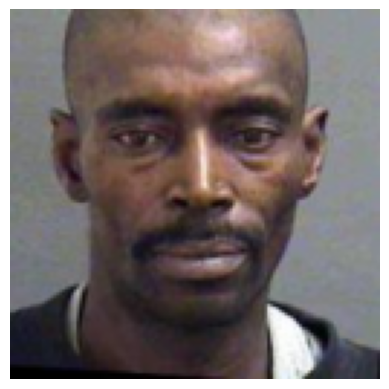

In [15]:
import matplotlib.pyplot as plt

sample_batch = next(iter(train_loader))

sample_image, _ = sample_batch

sample_image = sample_image[0].cpu().numpy().transpose(1, 2, 0)

sample_image = (sample_image * 0.5) + 0.5

plt.imshow(sample_image)
plt.axis("off")
plt.show()

In [16]:
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)

In [17]:
checkpoint_path = "./checkpoints/checkpoint_epoch_20.pth"

if os.path.exists(checkpoint_path):
	checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

	model.load_state_dict(checkpoint['model_state_dict'])
	optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

	start_epoch = checkpoint['epoch'] + 1
	last_loss = checkpoint['loss']

	print(f"Resuming training from Epoch {start_epoch} with last loss {last_loss:.4f}")
else:
	print(f"Checkpoint file not found at {checkpoint_path}. Starting training from scratch.")
	start_epoch = 0
	last_loss = None

Checkpoint file not found at ./checkpoints/checkpoint_epoch_20.pth. Starting training from scratch.


In [18]:
epochs = 20

In [19]:
for epoch in trange(start_epoch, epochs, desc="Epoch Progress", position=0, leave=True):
    model.train()
    total_loss = 0
    total_kl_loss = 0
    total_rec_loss = 0
    num_batches = len(train_loader)

    with tqdm(train_loader, desc=f"Training Epoch {epoch+1}", position=1, leave=False, dynamic_ncols=True) as pbar:
        for xb, yb in pbar:
            optimizer.zero_grad(set_to_none=True)

            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            kl_loss, outs = model(xb)

            reconstructed_loss = criterion(xb, outs)
            reconstructed_loss = reconstructed_loss/batch_size

            total_kl_loss += kl_loss.item()
            total_rec_loss += reconstructed_loss.item()

            loss = reconstructed_loss + beta * kl_loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    avg_train_loss = total_loss / num_batches
    avg_rec_loss = total_rec_loss / num_batches
    avg_kl_loss = total_kl_loss / num_batches

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", position=2, leave=False, dynamic_ncols=True) as pbar:
            for xb, yb in pbar:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)

                model = model.to(device)

                kl_loss, outs = model(xb)

                reconstructed_loss = criterion(xb, outs) / batch_size
                val_loss = reconstructed_loss + beta * kl_loss
                total_val_loss += val_loss.item()

                pbar.set_postfix({"Val Loss": val_loss.item()})

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, "
          f"Rec Loss: {avg_rec_loss:.4f}, "
          f"KL Loss: {avg_kl_loss:.4f}")

    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    checkpoint_filename = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
    save_checkpoint(model, optimizer, epoch, avg_train_loss, checkpoint_filename)

    scheduler.step(avg_val_loss)

Epoch Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/20 - Train Loss: 97.3298, Validation Loss: 0.6773, Rec Loss: 0.0033, KL Loss: 97.3264
Learning Rate: 0.010000


Training Epoch 2:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/20 - Train Loss: 0.7980, Validation Loss: 0.9526, Rec Loss: 0.0032, KL Loss: 0.7948
Learning Rate: 0.010000


Training Epoch 3:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/20 - Train Loss: 0.5761, Validation Loss: 0.2980, Rec Loss: 0.0032, KL Loss: 0.5729
Learning Rate: 0.010000


Training Epoch 4:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/20 - Train Loss: 0.2769, Validation Loss: 0.2014, Rec Loss: 0.0032, KL Loss: 0.2737
Learning Rate: 0.010000


Training Epoch 5:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/20 - Train Loss: 0.1877, Validation Loss: 0.2530, Rec Loss: 0.0032, KL Loss: 0.1845
Learning Rate: 0.010000


Training Epoch 6:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/20 - Train Loss: 0.1586, Validation Loss: 0.1570, Rec Loss: 0.0032, KL Loss: 0.1554
Learning Rate: 0.010000


Training Epoch 7:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/20 - Train Loss: 0.1237, Validation Loss: 1.1639, Rec Loss: 0.0032, KL Loss: 0.1205
Learning Rate: 0.010000


Training Epoch 8:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/20 - Train Loss: 0.0947, Validation Loss: 0.0224, Rec Loss: 0.0032, KL Loss: 0.0915
Learning Rate: 0.010000


Training Epoch 9:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/20 - Train Loss: 0.0159, Validation Loss: 0.0400, Rec Loss: 0.0032, KL Loss: 0.0127
Learning Rate: 0.010000


Training Epoch 10:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/20 - Train Loss: 0.0112, Validation Loss: 0.1131, Rec Loss: 0.0032, KL Loss: 0.0080
Learning Rate: 0.010000


Training Epoch 11:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/20 - Train Loss: 0.0140, Validation Loss: 0.0295, Rec Loss: 0.0032, KL Loss: 0.0108
Learning Rate: 0.010000


Training Epoch 12:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/20 - Train Loss: 0.0077, Validation Loss: 0.0303, Rec Loss: 0.0032, KL Loss: 0.0045
Learning Rate: 0.010000


Training Epoch 13:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/20 - Train Loss: 0.0054, Validation Loss: 0.0119, Rec Loss: 0.0032, KL Loss: 0.0022
Learning Rate: 0.001000


Training Epoch 14:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/20 - Train Loss: 0.0040, Validation Loss: 0.0039, Rec Loss: 0.0032, KL Loss: 0.0008
Learning Rate: 0.001000


Training Epoch 15:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/20 - Train Loss: 0.0039, Validation Loss: 0.0037, Rec Loss: 0.0032, KL Loss: 0.0007
Learning Rate: 0.001000


Training Epoch 16:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/20 - Train Loss: 0.0040, Validation Loss: 0.0041, Rec Loss: 0.0032, KL Loss: 0.0008
Learning Rate: 0.001000


Training Epoch 17:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/20 - Train Loss: 0.0039, Validation Loss: 0.0043, Rec Loss: 0.0032, KL Loss: 0.0007
Learning Rate: 0.001000


Training Epoch 18:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/20 - Train Loss: 0.0039, Validation Loss: 0.0047, Rec Loss: 0.0032, KL Loss: 0.0007
Learning Rate: 0.001000


Training Epoch 19:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/20 - Train Loss: 0.0040, Validation Loss: 0.0049, Rec Loss: 0.0032, KL Loss: 0.0008
Learning Rate: 0.001000


Training Epoch 20:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/20 - Train Loss: 0.0035, Validation Loss: 0.0034, Rec Loss: 0.0032, KL Loss: 0.0003
Learning Rate: 0.000100


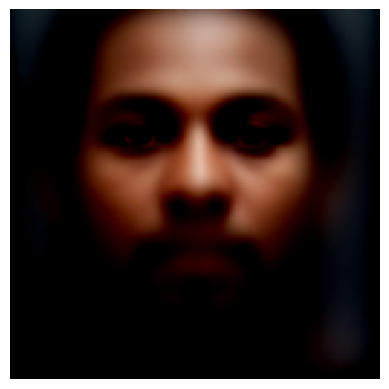

In [20]:
model.eval()
zsample = torch.randn(1, 200).to(device)

with torch.no_grad():
    gen_img = model.decoder(zsample).cpu().squeeze(0).numpy().transpose(1, 2, 0)
    plt.imshow(gen_img)
    plt.axis("off")
    plt.show()